# Executive Notebook: Tanzania Water Pump Project

Raven Welch & Clair Marie Wholean

__Project Goal__\
Predict water pump condition for waterpoints in Tanania. The customer is companies managing the waterpoints. Because a large percentage become non-functional in 2 years, they are looking to find out how to prevent pumps from becoming non-functional.  For this reason the analysis is focused on predicting the category "functional, needs repair."

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix 
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

## Preprocessing

### Functions

In [3]:
def impute_dataframe(dataframe):
    """Function takes in a dataframe and uses simple imputer to insert the 
    most frequent values.
    column_list = list of columns in the dataframe"""    
    cols = list(dataframe.columns)   
    from sklearn.impute import SimpleImputer     
    SI = SimpleImputer(missing_values=np.nan, strategy='most_frequent')   
    df_imputed = SI.fit_transform(dataframe)
    df_imputed = pd.DataFrame(data=df_imputed, columns=cols)
    return df_imputed

def change_column_type(dataframe, col_list):
    """Change certain columns in a dataframe to string
    col_list = the columns to be changed"""
    for col in col_list:
            dataframe[col] = dataframe[col].astype(str)
            
def one_hot_encoder(dataframe):
    """Function to one-hot encode a dataframe given a list of  columns of string or float (object) type.
    o_cols = object-type columns to be one-hot encoded"""   
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.compose import make_column_selector
    ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='error')   
    ct = ColumnTransformer(transformers=
                           [('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='error'),
                             make_column_selector(dtype_include=object))])
    dataframe = ct.fit_transform(dataframe)
    dataframe = pd.DataFrame(dataframe)
    return dataframe  

### Process Data

In [4]:
df = pd.read_csv('data/tanzania_values.csv')
df2 = pd.read_csv('data/tanzania_labels.csv')

#selected only columns related to the pump & water because the business goal is to prevent 
# pumps from becoming non-functional. 
df = df[['amount_tsh', 'permit', 'extraction_type', 'water_quality', 'quantity', 
                   'source', 'waterpoint_type']]

#missing values
df = impute_dataframe(df)

#list of the categorical columns that will be made string format.
obj_cols = ['permit', 'extraction_type', 'water_quality', 'quantity', 'source', 'waterpoint_type']
    
change_column_type(df, obj_cols)
change_column_type(df, obj_cols)

df = one_hot_encoder(df)

X_train, X_test, y_train, y_test = train_test_split(df, df2, test_size = 0.25, random_state = 47)

y_train = y_train['status_group']
y_test = y_test['status_group']

In [10]:
X_train.shape # 44550
X_test.shape # 14850 

(14850, 141)

# Modeling

## Iteration 1: Naive Bayes

In [41]:
NB = GaussianNB()

In [42]:
NB.fit(X_train, y_train)

GaussianNB()

In [45]:
NB.score(X_train, y_train)

0.10545454545454545

In [46]:
NB.score(X_test, y_test)

0.10632996632996633

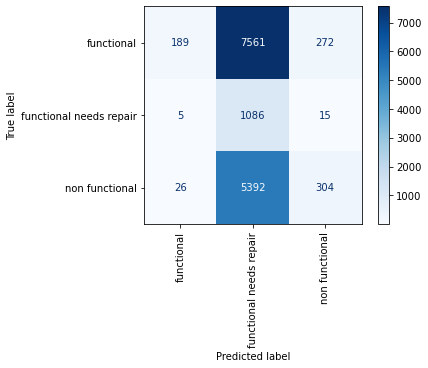

In [47]:
plot_confusion_matrix(NB, X_test, y_test, cmap = "Blues", xticks_rotation  = "vertical");

__Summary:__
- There were more errors than correct predictions for the column we are interested in, functional needs repair, so this model is not good.

## Iteration 2: Forest 2

In [48]:
forest2 = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_features = 10, max_depth = 10, min_samples_leaf = 20, min_samples_split = 3, random_state = 47)
forest2.fit(X_train, y_train)
forest2.score(X_test, y_test)

0.6686868686868687

__Summary:__
- This model is okay. We think we can do better.

## Iteration 3: Forest 3

In [49]:
forest3 = RandomForestClassifier(bootstrap = True, criterion = 'gini', random_state = 47, max_depth = 15, min_samples_leaf = 10, min_samples_split = 2)
forest3.fit(X_train, y_train)
forest3.score(X_test, y_test)

0.7057912457912457

In [50]:
y_test_pred = forest3.predict(X_test)

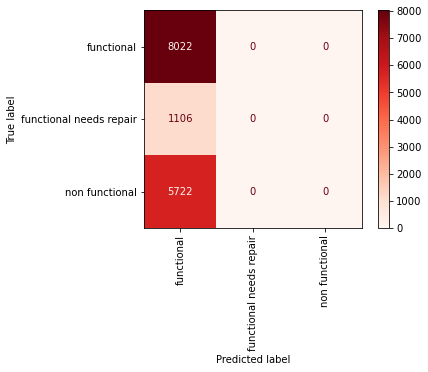

In [100]:
plot_confusion_matrix(forest3, X_test, y_test, cmap = "Reds", xticks_rotation  = "vertical");

__Summary:__
- The functional, needs repair category had 0 correct predictions.
- Try other methods.

### Scaling

In [54]:
ss = StandardScaler()

X_train_scales = ss.fit_transform(X_train)
X_test_scales = ss.transform(X_test)

In [55]:
forest3.fit(X_train_scales, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, random_state=47)

In [56]:
forest3.score(X_test_scales, y_test)

0.7057912457912457

In [95]:
y_pred = forest3.predict(X_test)
print(classification_report(y_test, y_pred, 
                            target_names = ['functional', 'functional needs repair', 'non functional']))

                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      8022
functional needs repair       0.00      0.00      0.00      1106
         non functional       0.00      0.00      0.00      5722

               accuracy                           0.54     14850
              macro avg       0.18      0.33      0.23     14850
           weighted avg       0.29      0.54      0.38     14850



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


__Summary:__
- This model seems to be decent from the accuracy score, but the precision shows that it is correctly predicting 2/3 categories 0% of the time. We'll try some hyperparameter tuning.

### Gridsearch

In [73]:
# the cv parameter is not passed, so the default of 5 folds is used for cross-validation. 
params = {
    'random_state': [47],
    'criterion' : ["gini", "entropy"],
    'max_depth' : [3, 5, 10],
    'min_samples_split' : [2, 50],
    'min_samples_leaf' : [20, 50],
    'max_features' : [5, 10],
    'bootstrap' : [True],
}

gs = GridSearchCV(forest3, params)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                              random_state=47),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10], 'max_features': [5, 10],
                         'min_samples_leaf': [20, 50],
                         'min_samples_split': [2, 50], 'random_state': [47]})

In [74]:
gs.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'random_state': 47}

### Re-do Forest 3 with Params from GridSearch

In [75]:
forest3A = RandomForestClassifier(bootstrap = True, criterion = 'entropy', random_state = 47, max_depth = 10, min_samples_leaf = 20, min_samples_split = 2)
forest3A.fit(X_train, y_train)
forest3A.score(X_test, y_test)

0.6674074074074074

In [96]:
y_pred = forest3A.predict(X_test)
print(classification_report(y_test, y_pred, 
                            target_names = ['functional', 'functional needs repair', 'non functional']))

                         precision    recall  f1-score   support

             functional       0.64      0.94      0.76      8022
functional needs repair       0.00      0.00      0.00      1106
         non functional       0.80      0.41      0.54      5722

               accuracy                           0.67     14850
              macro avg       0.48      0.45      0.43     14850
           weighted avg       0.65      0.67      0.62     14850



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


__Summary:__
- This set of parameters made the model accuracy worse, but the precision is better. 
- Functional was correctly predicted 64% of the time. 
- Non-functional was correctly predicted 80% of the time. 
- Functional needs repair was correctly predicted 0% of the time. This is our priority category, so let's keep going. 
- We'll try a grid search with a different set of hyperparameters.

### Making Another Round of Params

In [76]:
# parmas2 goes into the pipeline 
# the cv parameter is not passed, so the default of 5 folds is used for cross-validation. 
params2 = {
    'bootstrap' : [True],
    'random_state': [47],
    'criterion' : ["gini"],  
    'max_depth' : [10, 15],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [10, 20],
    'max_features' : [10, 15],
}
forest = RandomForestClassifier()

gs2 = GridSearchCV(forest3, params2)
gs2.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                              random_state=47),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [10, 15], 'max_features': [10, 15],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [2, 5], 'random_state': [47]})

In [78]:
#Use this cell for best model
gs2.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'random_state': 47}

### Re-do Forest 3 with Params2 from GridSearch

In [79]:
forest3B = RandomForestClassifier(bootstrap = True, criterion = 'gini', random_state = 47, max_depth = 15, min_samples_leaf = 10, min_samples_split = 2)
forest3B.fit(X_train, y_train)
forest3B.score(X_test, y_test)

0.7057912457912457

In [97]:
y_pred = forest3B.predict(X_test)
print(classification_report(y_test, y_pred, 
                            target_names = ['functional', 'functional needs repair', 'non functional']))

                         precision    recall  f1-score   support

             functional       0.67      0.93      0.78      8022
functional needs repair       0.00      0.00      0.00      1106
         non functional       0.81      0.53      0.64      5722

               accuracy                           0.71     14850
              macro avg       0.49      0.49      0.47     14850
           weighted avg       0.67      0.71      0.67     14850



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


__Summary:__
- This model is pretty good, but we're still getting 0% prediction for functional needs repair. 
- Now we'll put it into a pipeline with scaling.

## Iteration 4: Pipeline - Best Model

In [83]:
#pipeline is running a classifier that has specified params

pipe1 = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(bootstrap = True, criterion = 'gini', 
                           random_state = 47, max_depth = 15, max_features = 15, 
                           min_samples_leaf = 10, min_samples_split = 2))

pipe1.fit(X_train, y_train)
pipe1.score(X_test, y_test)

0.7132659932659933

In [98]:
y_pred = pipe1.predict(X_test)
print(classification_report(y_test, y_pred, 
                            target_names = ['functional', 'functional needs repair', 'non functional']))

                         precision    recall  f1-score   support

             functional       0.68      0.92      0.78      8022
functional needs repair       0.52      0.03      0.05      1106
         non functional       0.81      0.55      0.65      5722

               accuracy                           0.71     14850
              macro avg       0.67      0.50      0.50     14850
           weighted avg       0.72      0.71      0.68     14850



__Summary:__
- The RandomForest performs a little better with min-max scaler. 

In [94]:
pipe2 = make_pipeline(
    MinMaxScaler(),
    DecisionTreeClassifier(random_state=47))

pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test) 

0.7330639730639731

In [89]:
y_pred = pipe2.predict(X_test)
print(classification_report(y_test, y_pred, 
                            target_names = ['functional', 'functional needs repair', 'non functional']))

                         precision    recall  f1-score   support

             functional       0.70      0.91      0.79      8022
functional needs repair       0.48      0.11      0.18      1106
         non functional       0.82      0.60      0.69      5722

               accuracy                           0.73     14850
              macro avg       0.67      0.54      0.56     14850
           weighted avg       0.73      0.73      0.71     14850



__Summary:__
- The decision tree performs even better with min-max scaler. 
- This is our best model in terms of overall accuracy.
- The model correctly predicted functional pumps 70% of the time.
- The model correctly predicted non-functional 82% of the time. 
- The model correctly predicted functional needs repair 48% of the time. This is not great, but we know that there is a class imbalance for this category. It is much improved over the forest3 model that had 0%. Since both the decision tree and random forest are predicting functional needs repair roughly equivalent to chance, this means that the class imbalance needs to be addressed and/or more data for this category is needed.
- The random forest (pipe1) performed slightly better for functional needs repair at 52%, so this model could also be used. 